<p class="alert alert-success" style="padding:1em">
To use SMT models, please follow the link :
</p>

https://github.com/SMTorg/SMT/blob/master/README.md


<p class="alert alert-success" style="padding:1em">
The doc is available here:
</p>

https://smt.readthedocs.io/en/latest/

<div class="jumbotron text-left"><b>
We are interested in learning a high-fidelity function while using low-fidelity information sources to enhance the model, for that we use the auto-regressive formulation of Kennedy O'Hagan/Le Gratiet. To have more details,

*   Kennedy, M.C. and O’Hagan, A., Bayesian calibration of computer models. Journal of the Royal Statistical Society. 2001
*  Le Gratiet, L., Multi-fidelity Gaussian process regression for computer experiments. PhD Thesis. 2013

The `MFK` approach available in SMT assumes to have a nested DOE between the different fidelity levels ([tutorial notebooks](https://github.com/SMTorg/smt/tree/master/tutorial/MFK)).

Here we extend the approach for any DOE (nested or not), and this tutorial describes how to use **a co-kriging approach**, called `MFCK`.

This `MFCK` approach is able to deal with:

*   nested  DOE (and in this case can be compared to the `MFK` approach)
*   non nested DOE


</b></div>

Mauricio Castano Aguirre, October 2024. based on `smt 2.7.0`

Nathalie Bartoli ONERA/DTIS/M2CI

# 1- Installing SMT

In [1]:
!pip install smt

You should consider upgrading via the 'D:\mcastano\.pyenv\pyenv-win\versions\3.11.0b3\python.exe -m pip install --upgrade pip' command.


## 1.1 Imports

In [2]:
from smt.applications import MFCK
from smt.applications import MFK
from smt.applications.mfk import NestedLHS
from smt.sampling_methods import LHS
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

## 1.2 Build the multi-fidelity setup

For this tutorial we'll use de Forrester functions, well known functions in the multi-fidelity context, the base function is defined by:
$$
f(x)=(6x-2)^2\sin(12x-4)
$$

The function can be defined on any input domain but in this case will be evaluated on $x\in[0.0,1.0]$

The Forrester function is a relatively simple mathematical function used to test the performance of surrogate models. It is nonlinear, unimodal, and smooth, making it ideal for testing how well surrogate models or algorithms can approximate or optimize a function based on limited high-fidelity data.

In this context we define 3 different fidelity levels based on the forrester function for the 1D experiments

In [3]:
def Forrester_HF(x):
    return ((x * 6 - 2) ** 2) * np.sin((x * 6 - 2) * 2)


def Forrester_LF(x):
    return 0.5 * ((x * 6 - 2) ** 2) * np.sin((x * 6 - 2) * 2) + (x - 0.5) * 10.0 - 5


def Forrester_MF(x):
    return ((x * 6 - 2) ** 2) * np.sin((x * 6 - 2) * 2) + (x - 0.2) * 2.0 - 2

# 2- Multi-Fidelity co-Kriging: 1D and 2 levels

We are interested in learning a high-fidelity function while using low-fidelity information sources to enhance the model, for that we use the auto-regressive formulation of Kennedy O'Hagan/Le Gratiet (see above for references).



<p class="alert alert-warning" style="padding:1em">
For this `MFCK` formulation, a nested DoE is not necessary.
 </p>
    

### Kennedy O'Hagan/Le Gratiet auto-regressive formulation:
To perform the co-kriging, we first need to introduce the auto-regressive formulation, we learn the relationship between every two consecutive fidelity levels (scaling factor $\rho_{k-1}$ and discrepancy function $\gamma_k(\cdot)$ are used for that).

$$
    Y_{k} = \rho_{k}\;Y_{k-1} + \gamma_k\\ k>0
$$

In this case we have the lowest fidelity $Y_{0}\sim\mathcal{GP}(0,K(\cdot,\cdot))$, $\rho_{k}$ being a scale factor and $\gamma_k\sim\mathcal{GP}({0,K(\cdot,\cdot)})$. To measure the discrepancies between $Y_{k}$ and $Y_{k-1}$. After, we model the higher fidelity level using the auto-regressive formulation.

We define $K(\cdot,\cdot)$ as some kernel function for covariance calculation.

This generally results in a better surrogate model compared to training the high-fidelity alone.

The idea is to compare
- the nested formulation (`MFK`) where $$X_{HF} \subset X_{LF}$$
- and the non nested one (`MFCK`).

In [4]:
# Some parameters for Hyperparameter optimization
n_start = 100
opti = "Cobyla"

In [5]:
N = 100  # Number of samples for validation
xlimits = np.array(
    [[0.0, 1.0]]
)  # limits of x for the test vector, and limits for the plots
ylimits = np.array([[-15.0, 17.0]])  # used for  y limits of plots


x = np.linspace(xlimits[0][0], xlimits[0][1], N, endpoint=True).reshape(-1, 1)
LF = Forrester_LF(x)
HF = Forrester_HF(x)

Text(0, 0.5, '$y$')

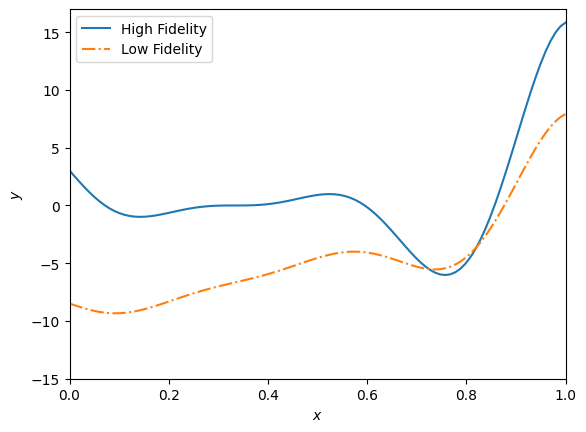

In [6]:
# Ploting High and low fidelity functions
plt.figure()
plt.plot(x, HF, label="High Fidelity")
plt.plot(x, LF, linestyle="-.", label="Low Fidelity")
plt.legend(loc=0)
plt.ylim(ylimits[0][0], ylimits[0][1])
plt.xlim(xlimits[0][0], xlimits[0][1])
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")

## 2.1 Sampling for 2 levels
The idea here is the same as the MFK example, we want to cover as much space as possible with low-fidelity data and use enough high fidelity samples to learn the relationship between fidelity levels.

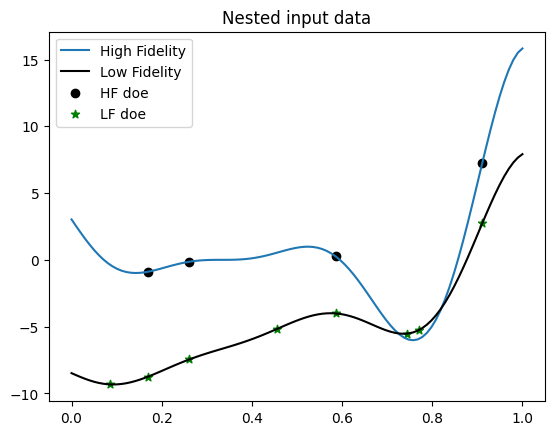

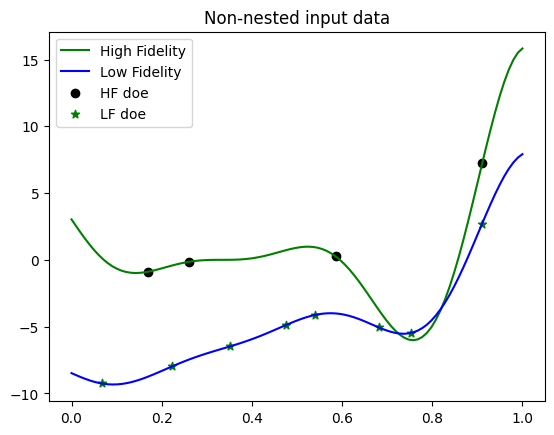

In [7]:
# LHS sampling with 2 levels of fidelity
ndim = 1  # 1 dimension example
nlvl = 2  # 2 levels
ndoe_HF = 4  # 4 high fidelity points

# Nested DOE
xlimits = np.array([[0.0, 1.0]])
xdoes = NestedLHS(nlevel=nlvl, xlimits=xlimits, random_state=51)

# seeds 2, 9, 12, 51
xt_c, xt_e = xdoes(ndoe_HF)
ndoe_LF = np.shape(xt_c)[0]
yt_e = Forrester_HF(xt_e)
yt_c = Forrester_LF(xt_c)


# Creation of non-nested input data using LHS points for LF
sampling = LHS(xlimits=xlimits, criterion="ese")

x0_LF = sampling(ndoe_LF)
x0_HF = xt_e
y0_LF = Forrester_LF(x0_LF)
y0_HF = Forrester_HF(x0_HF)

plt.figure()
plt.title("Nested input data")
plt.plot(x, HF, label="High Fidelity")
plt.plot(x, LF, c="k", label="Low Fidelity")
plt.scatter(xt_e, yt_e, marker="o", color="k", label="HF doe")
plt.scatter(xt_c, yt_c, marker="*", color="g", label="LF doe")
plt.legend()

plt.figure()
plt.title("Non-nested input data")
plt.plot(x, HF, c="g", label="High Fidelity")
plt.plot(x, LF, c="b", label="Low Fidelity")
plt.scatter(x0_HF, y0_HF, marker="o", color="k", label="HF doe")
plt.scatter(x0_LF, y0_LF, marker="*", color="g", label="LF doe")
plt.legend()

## 2.2 Training the model for 2 levels 1D

### 2.2.1-Training for the nested input data

In [8]:
# Initial parameters for the models
theta0 = [1.0]
theta_bounds = [1e-2, 13.0]

# MFCK model
mfck = MFCK(theta0=theta0, theta_bounds=theta_bounds, hyper_opt=opti, n_start=n_start)
mfck.set_training_values(xt_c, yt_c, name=0)
mfck.set_training_values(xt_e, yt_e)
mfck.train()

m, c = mfck.predict_all_levels(x)
medianmf0 = m[1]
varmf0 = c[1]
medianmf1 = m[0]
varmf1 = c[0]

varmf0 = np.diag(varmf0).reshape(-1, 1)
varmf1 = np.diag(varmf1).reshape(-1, 1)

# MFK model
sm = MFK(
    hyper_opt=opti,
    theta0=theta0,
    theta_bounds=theta_bounds,
    propagate_uncertainty=True,
    n_start=n_start,
)
sm.set_training_values(xt_c, yt_c, name=0)
sm.set_training_values(xt_e, yt_e)
sm.train()

# HF
mean_nmf_hfn = sm.predict_values(x)
va_nmf_hfn = sm.predict_variances(x)
# LF
mean_nmf_lfn = sm._predict_intermediate_values(x, 1)
va_nmf_lfn, _ = sm.predict_variances_all_levels(x)
va_nmf_lfn = va_nmf_lfn[:, 0].reshape(-1, 1)

___________________________________________________________________________
   
                                    MFK
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 4
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.3282611
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 100
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   


In [9]:
# here with 2 levels we have 2 hyperparameters
print("Optimal hyperparameters for MFK", sm.optimal_theta)

Optimal hyperparameters for MFK [array([1.08935682]), array([0.01])]


In [10]:
# here with 2 levels we have 5 hyperparameters
print("Optimal hyperparameters for MFCK", mfck.optimal_theta)

Optimal hyperparameters for MFCK [2.08434558 1.70316024 2.30263219 0.11122577 1.43992217]


As explained at the begining we have the following auto-regressive formulation
$$
    Y_{k} = \rho_{k}\;Y_{k-1} + \gamma_k\\ k>0
$$

In this case we have the lowest fidelity $Y_{0}\sim\mathcal{GP}(0,K(\cdot,\cdot))$, $\rho_{k}$ being a scale factor and $\gamma_k\sim\mathcal{GP}({0,K(\cdot,\cdot)})$ to measure the discrepancies between $Y_{k}$ and $Y_{k-1}$. After, we model the higher fidelity levels using the auto-regressive formulation.

We define $K(\cdot,\cdot)$ as some kernel function for covariance calculation

This kernel function has Hyper-parameters (HP) $\Theta=\{\sigma^2,\theta\}$

In this context if we want to run MFCK for 2 fidelity levels we have the set of HP of the level $Y_{0}$ and the set of HP given by the next level $Y_{k}$,

$$
\Theta=\{\sigma^2_0,\theta_0,\sigma^2_{\gamma_{1}},\theta_{\gamma_{1}},\rho_1 \}
$$

being $\sigma^2_0,\theta_0$ the HP for the kernel for the level $0$ and $\sigma^2_\gamma,\theta_\gamma,\rho$ the HP for the estimation of the next level using the auto-regressive formulation.

Each set of HP $\sigma^2_{\gamma_{k}},\theta_{\gamma_{k}},\rho_k$ must be added per level of fidelity. For example, for three fidelity levels the set of HP is : $\Theta=\{\sigma^2_0,\theta_0,\sigma^2_{\gamma_{1}},\theta_{\gamma_{1}},\rho_1, \sigma^2_{\gamma_{2}},\theta_{\gamma_{2}},\rho_2 \}$



<p class="alert alert-warning" style="padding:1em">

In the case of **MFCK** the optimization complexity is higher due to the block-wise matrix formulation, in which all hyperparameters are optimized in a single process, contrary to MFK, where the hyperparameters are optimized sequentially.

 </p>

### 2.2.2 -Training for non-nested input data

In [11]:
# Using MFK
sm1 = MFK(
    theta0=theta0,
    theta_bounds=theta_bounds,
    propagate_uncertainty=True,
    n_start=n_start,
)
sm1.set_training_values(x0_LF, y0_LF, name=0)
sm1.set_training_values(x0_HF, y0_HF)
sm1.train()

mean_nmf_hf = sm1.predict_values(x)
va_nmf_hf = sm1.predict_variances(x)

mean_nmf_lf = sm1._predict_intermediate_values(x, 1)
var0, _ = sm1.predict_variances_all_levels(x)
var0 = var0[:, 0].reshape(-1, 1)

# Using MFCK
mfck1 = MFCK(hyper_opt=opti, n_start=n_start)
mfck1.set_training_values(x0_LF, y0_LF, name=0)
mfck1.set_training_values(x0_HF, y0_HF)
mfck1.train()
mn, cn = mfck1.predict_all_levels(x)


# MFGP HF mean and variance
a = mn[1]
m = cn[1]

# MFGP LF mean and variance
a1 = mn[0]
m1 = cn[0]

___________________________________________________________________________
   
                                    MFK
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 4
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.7916780
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 100
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   


## 2.3 Plotting results for 2 levels 1D

Text(0.5, 1.0, 'MFCK, non-nested input data')

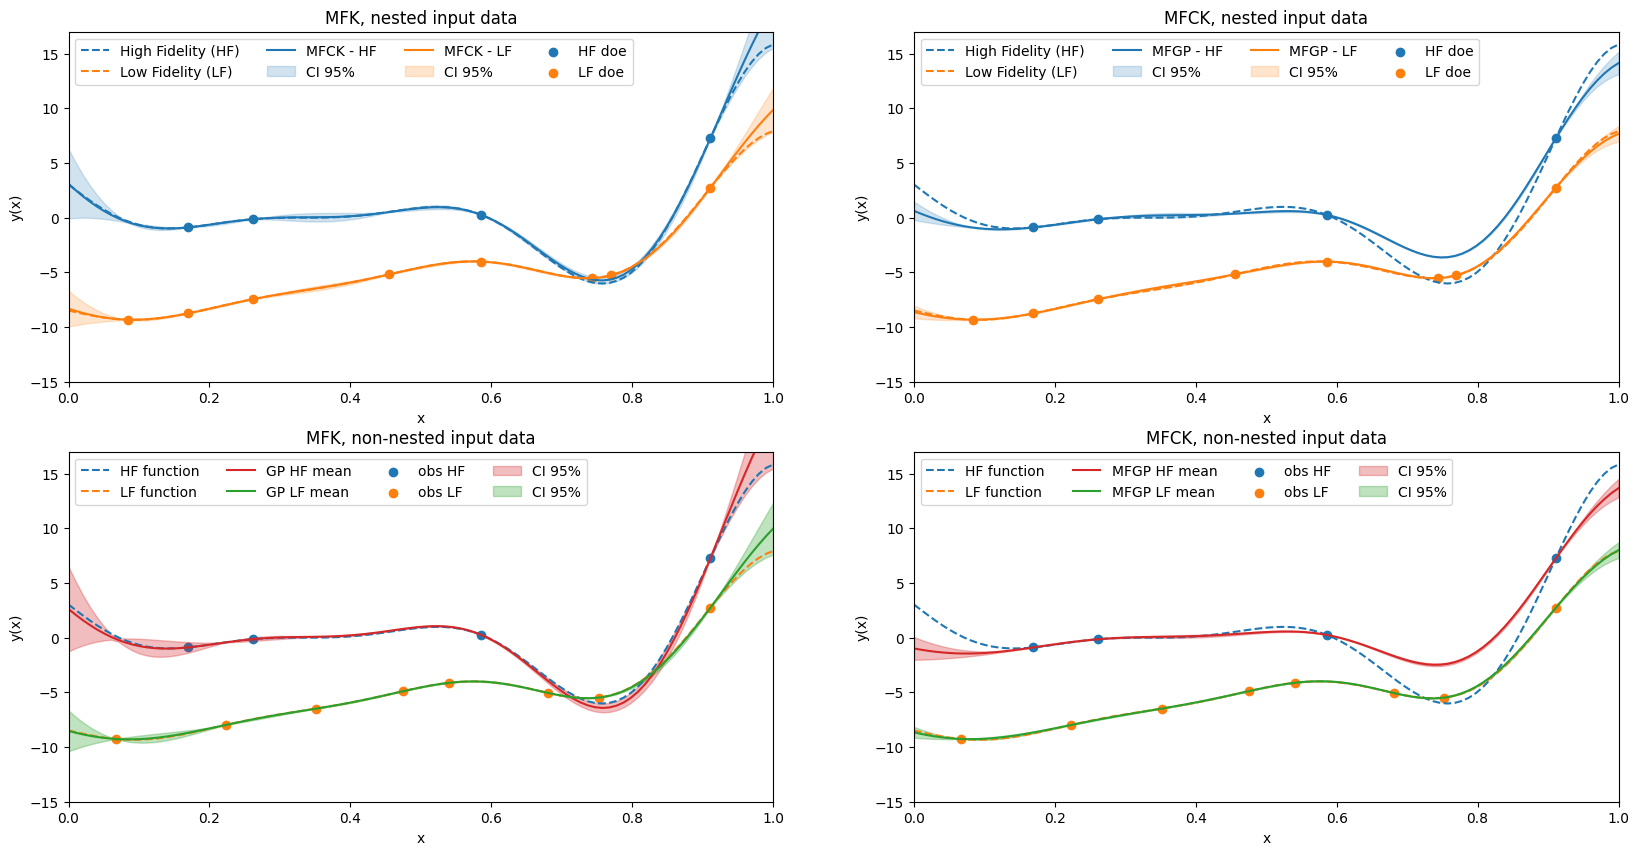

In [12]:
plt.figure(figsize=(20, 10))

plt.subplot(2, 2, 1)
plt.plot(x, HF, "--C0", label="High Fidelity (HF)")
plt.plot(x, LF, "--C1", label="Low Fidelity (LF)")
plt.plot(x, mean_nmf_hfn, "C0", label="MFCK - HF")
plt.fill_between(
    np.ravel(x),
    np.ravel(mean_nmf_hfn - 1.96 * np.sqrt(va_nmf_hfn)),
    np.ravel(mean_nmf_hfn + 1.96 * np.sqrt(va_nmf_hfn)),
    color="C0",
    alpha=0.2,
    label="CI 95%",
)
plt.plot(x, mean_nmf_lfn, "C1", label="MFCK - LF")
plt.fill_between(
    np.ravel(x),
    np.ravel(mean_nmf_lfn - 1.96 * np.sqrt(va_nmf_lfn)),
    np.ravel(mean_nmf_lfn + 1.96 * np.sqrt(va_nmf_lfn)),
    color="C1",
    alpha=0.2,
    label="CI 95%",
)


plt.scatter(xt_e, yt_e, color="C0", label="HF doe")
plt.scatter(xt_c, yt_c, color="C1", label="LF doe")

plt.ylim(ylimits[0][0], ylimits[0][1])
plt.xlim(xlimits[0][0], xlimits[0][1])
plt.xlabel("x")
plt.ylabel("y(x)")
plt.legend(loc=2, ncol=4)
plt.title("MFK, nested input data")

plt.subplot(2, 2, 2)
plt.plot(x, HF, "--C0", label="High Fidelity (HF)")
plt.plot(x, LF, "--C1", label="Low Fidelity (LF)")
plt.plot(x, medianmf0, "C0", label="MFGP - HF")

plt.fill_between(
    np.ravel(x),
    np.ravel(medianmf0 - 1.96 * np.sqrt(varmf0)),
    np.ravel(medianmf0 + 1.96 * np.sqrt(varmf0)),
    color="C0",
    alpha=0.2,
    label="CI 95%",
)
plt.plot(x, medianmf1, "C1", label="MFGP - LF")
plt.fill_between(
    np.ravel(x),
    np.ravel(medianmf1 - 1.96 * np.sqrt(varmf1)),
    np.ravel(medianmf1 + 1.96 * np.sqrt(varmf1)),
    color="C1",
    alpha=0.2,
    label="CI 95%",
)


plt.scatter(xt_e, yt_e, color="C0", label="HF doe")
plt.scatter(xt_c, yt_c, color="C1", label="LF doe")
plt.ylim(ylimits[0][0], ylimits[0][1])
plt.xlim(xlimits[0][0], xlimits[0][1])
plt.xlabel("x")
plt.ylabel("y(x)")
plt.legend(loc=2, ncol=4)
plt.title("MFCK, nested input data")


plt.subplot(2, 2, 3)
# plot LF and HF target functions
plt.plot(x, HF, "C0--", label="HF function")
plt.plot(x, LF, "C1--", label="LF function")
plt.plot(x, mean_nmf_hf, "C3", label="GP HF mean")
plt.plot(x, mean_nmf_lf, "C2", label="GP LF mean")
plt.scatter(x0_HF, y0_HF, color="C0", label="obs HF")
plt.scatter(x0_LF, y0_LF, color="C1", label="obs LF")
upperBound = mean_nmf_hf.flatten() + 1.96 * np.sqrt(np.abs((va_nmf_hf.flatten())))
lowerBound = mean_nmf_hf.flatten() - 1.96 * np.sqrt(np.abs((va_nmf_hf.flatten())))
upperBound1 = mean_nmf_lf.flatten() + 1.96 * np.sqrt(np.abs((var0.flatten())))
lowerBound1 = mean_nmf_lf.flatten() - 1.96 * np.sqrt(np.abs((var0.flatten())))
plt.fill_between(
    x.flatten(),
    lowerBound.flatten(),
    upperBound.flatten(),
    label="CI 95%",
    color="C3",
    alpha=0.3,
)
plt.fill_between(
    x.flatten(),
    lowerBound1.flatten(),
    upperBound1.flatten(),
    label="CI 95%",
    color="C2",
    alpha=0.3,
)
plt.ylim(ylimits[0][0], ylimits[0][1])
plt.xlim(xlimits[0][0], xlimits[0][1])
plt.xlabel("x")
plt.ylabel("y(x)")
plt.legend(loc=2, ncol=4)
plt.title("MFK, non-nested input data")
plt.subplot(2, 2, 4)
plt.plot(x, HF, "C0--", label="HF function")
plt.plot(x, LF, "C1--", label="LF function")
plt.plot(x, a, "C3", label="MFGP HF mean")
plt.plot(x, a1, "C2", label="MFGP LF mean")
plt.scatter(x0_HF, y0_HF, color="C0", label="obs HF")
plt.scatter(x0_LF, y0_LF, color="C1", label="obs LF")
upperBound2 = a.flatten() + 1.96 * np.sqrt(np.diag(m))
lowerBound2 = a.flatten() - 1.96 * np.sqrt(np.diag(m))
upperBound3 = a1.flatten() + 1.96 * np.sqrt(np.diag(m1))
lowerBound3 = a1.flatten() - 1.96 * np.sqrt(np.diag(m1))
plt.fill_between(
    x.flatten(),
    lowerBound2.flatten(),
    upperBound2.flatten(),
    label="CI 95%",
    color="C3",
    alpha=0.3,
)
plt.fill_between(
    x.flatten(),
    lowerBound3.flatten(),
    upperBound3.flatten(),
    label="CI 95%",
    color="C2",
    alpha=0.3,
)
plt.ylim(ylimits[0][0], ylimits[0][1])
plt.xlim(xlimits[0][0], xlimits[0][1])
plt.xlabel("x")
plt.ylabel("y(x)")
plt.legend(loc=2, ncol=4)
plt.title("MFCK, non-nested input data")

## 2.4 RMSE comparison between MFK and MFCK for 2 levels, 1D

In [13]:
# Add RMSE

# MFCK: RMSE HF non-nested
rmseHF = np.sqrt(np.mean((HF.flatten() - a.flatten()) ** 2))
# RMSE Low Fidelity non-nested
rmseLF = np.sqrt(np.mean((LF.flatten() - a1.flatten()) ** 2))

# MFK: RMSE HF non-nested
rmseHF1 = np.sqrt(np.mean((HF.flatten() - mean_nmf_hf.flatten()) ** 2))
# RMSE LF non-nested
rmseLF1 = np.sqrt(np.mean((LF.flatten() - mean_nmf_lf.flatten()) ** 2))


# MFCK: RMSE HF nested
rmseHF2 = np.sqrt(np.mean((HF.flatten() - medianmf0.flatten()) ** 2))
#      RMSE LF nested
rmseLF2 = np.sqrt(np.mean((LF.flatten() - medianmf1.flatten()) ** 2))

# MFK: RMSE LF nested
rmseHF3 = np.sqrt(np.mean((HF.flatten() - mean_nmf_hfn.flatten()) ** 2))
#      RMSE LF nested
rmseLF3 = np.sqrt(np.mean((LF.flatten() - mean_nmf_lfn.flatten()) ** 2))

print("RMSE for nested")
print("           HF                     LF")
print("MFK  :", rmseHF3, rmseLF3)
print("MFCK :", rmseHF2, rmseLF2)


print("\n")

print("RMSE for non-nested ")
print("           HF                     LF")
print("MFK  :", rmseHF1, rmseLF1)
print("MFCK :", rmseHF, rmseLF)

RMSE for nested
           HF                     LF
MFK  : 0.551469670625042 0.29749987197214917
MFCK : 1.1709163708554997 0.09553418759042226


RMSE for non-nested 
           HF                     LF
MFK  : 0.7506754535147545 0.31772666347031897
MFCK : 1.747765752872187 0.06534256108475182


## 2.5 To compare with mono fidelity GP using only HF data

In [14]:
print(yt_e, y0_HF)

[[-0.89542054]
 [ 0.25578692]
 [ 7.25954836]
 [-0.14275691]] [[-0.89542054]
 [ 0.25578692]
 [ 7.25954836]
 [-0.14275691]]


In [15]:
# to compare with mono-fidelity GP build on HF data
# Build the KRG object
from smt.surrogate_models import KRG

gp = KRG(theta0=theta0, theta_bounds=theta_bounds)
# high-fidelity dataset non nested = nested data for HF (xt_e,yt_e) = (x0_HF, y0_HF)
gp.set_training_values(xt_e, yt_e)
# train the model
gp.train()

# prediction and variances associated
gp_y = gp.predict_values(x)
gp_var = gp.predict_variances(x)

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 4
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.0730557
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 100
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   


Text(0.5, 1.0, 'Mono or MultiFi Kriging (non nested input data - 2 levels)')

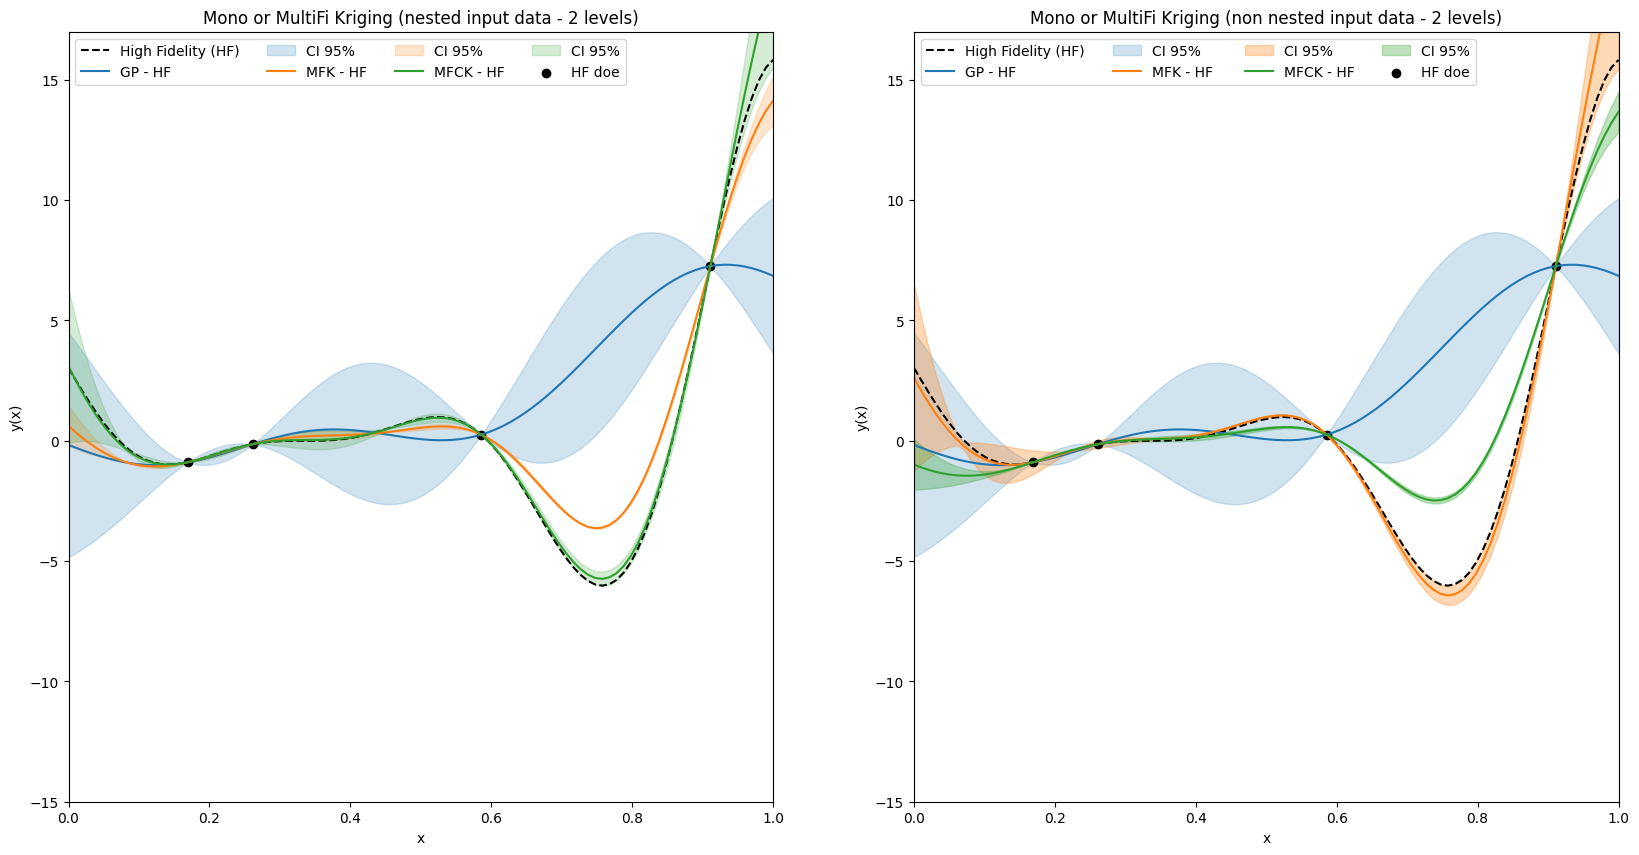

In [16]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(x, Forrester_HF(x), "k--", label="High Fidelity (HF)")

plt.plot(x, gp_y, "C0", label="GP - HF")
plt.fill_between(
    np.ravel(x),
    np.ravel(gp_y - 1.96 * np.sqrt(gp_var)),
    np.ravel(gp_y + 1.96 * np.sqrt(gp_var)),
    color="C0",
    alpha=0.2,
    label="CI 95%",
)

plt.plot(x, medianmf0, "C1", label="MFK - HF")

plt.fill_between(
    np.ravel(x),
    np.ravel(medianmf0 - 1.96 * np.sqrt(varmf0)),
    np.ravel(medianmf0 + 1.96 * np.sqrt(varmf0)),
    color="C1",
    alpha=0.2,
    label="CI 95%",
)

plt.plot(x, mean_nmf_hfn, "C2", label="MFCK - HF")
plt.fill_between(
    np.ravel(x),
    np.ravel(mean_nmf_hfn - 1.96 * np.sqrt(va_nmf_hfn)),
    np.ravel(mean_nmf_hfn + 1.96 * np.sqrt(va_nmf_hfn)),
    color="C2",
    alpha=0.2,
    label="CI 95%",
)

plt.scatter(xt_e, yt_e, color="black", label="HF doe")


plt.ylim(ylimits[0][0], ylimits[0][1])
plt.xlim(xlimits[0][0], xlimits[0][1])
plt.xlabel("x")
plt.ylabel("y(x)")
plt.legend(loc=2, ncol=4)
plt.title("Mono or MultiFi Kriging (nested input data - 2 levels)")


plt.subplot(1, 2, 2)
plt.plot(x, Forrester_HF(x), "k--", label="High Fidelity (HF)")


plt.plot(x, gp_y, "C0", label="GP - HF")
plt.fill_between(
    np.ravel(x),
    np.ravel(gp_y - 1.96 * np.sqrt(gp_var)),
    np.ravel(gp_y + 1.96 * np.sqrt(gp_var)),
    color="C0",
    alpha=0.2,
    label="CI 95%",
)

plt.plot(x, mean_nmf_hf, "C1", label="MFK - HF ")
upperBound = mean_nmf_hf.flatten() + 1.96 * np.sqrt(np.abs((va_nmf_hf.flatten())))
lowerBound = mean_nmf_hf.flatten() - 1.96 * np.sqrt(np.abs((va_nmf_hf.flatten())))
plt.fill_between(
    x.flatten(),
    lowerBound.flatten(),
    upperBound.flatten(),
    label="CI 95%",
    color="C1",
    alpha=0.3,
)

plt.plot(x, a, "C2", label="MFCK - HF")
upperBound2 = a.flatten() + 1.96 * np.sqrt(np.diag(m))
lowerBound2 = a.flatten() - 1.96 * np.sqrt(np.diag(m))
plt.fill_between(
    x.flatten(),
    lowerBound2.flatten(),
    upperBound2.flatten(),
    label="CI 95%",
    color="C2",
    alpha=0.3,
)

plt.scatter(x0_HF, y0_HF, color="black", label="HF doe")

plt.ylim(ylimits[0][0], ylimits[0][1])
plt.xlim(xlimits[0][0], xlimits[0][1])
plt.xlabel("x")
plt.ylabel("y(x)")
plt.legend(loc=2, ncol=4)
plt.title("Mono or MultiFi Kriging (non nested input data - 2 levels)")

# 3- Multi-Fidelity co-Kriging: Experiment for 3 levels 1D

In this example, we compare the same models by adding another level of fidelity using the Forrester functions (HF, MF et LF defined in the beginning).

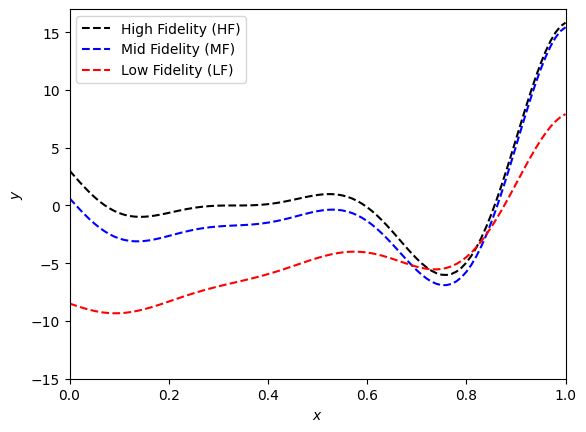

In [17]:
x = np.linspace(0, 1, 101, endpoint=True).reshape(-1, 1)
plt.figure()
plt.plot(x, Forrester_HF(x), "--k", label="High Fidelity (HF)")
plt.plot(x, Forrester_MF(x), "--b", label="Mid Fidelity (MF)")
plt.plot(x, Forrester_LF(x), "--r", label="Low Fidelity (LF)")
plt.legend(loc=0)
plt.ylim(ylimits[0][0], ylimits[0][1])
plt.xlim(xlimits[0][0], xlimits[0][1])
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()

## 3.1 Sampling for 3 levels

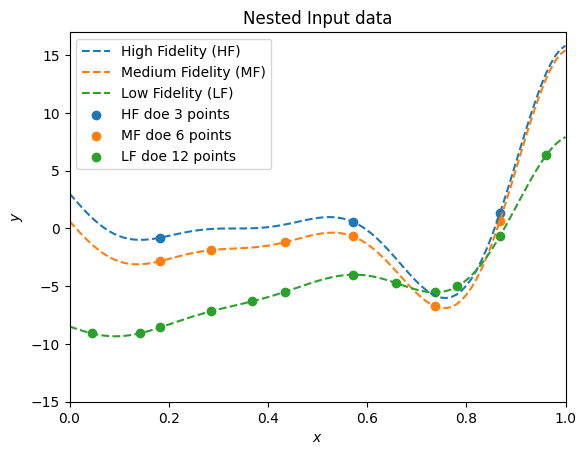

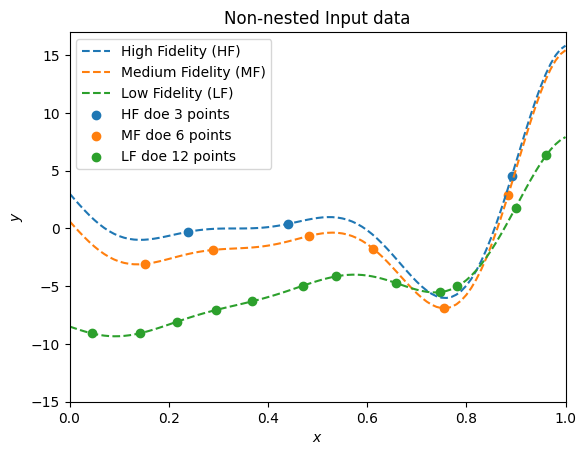

In [18]:
# LHS sampling with nested DOE: 3 levels, 1 dimension, 3 HF points
ndim = 1
nlvl = 3
ndoe_hf = 3
random_state = 0

xdoes = NestedLHS(nlevel=nlvl, xlimits=xlimits, random_state=random_state)
Xt_c, Xt_m, Xt_e = xdoes(ndoe_hf)

Xt_e = np.sort(Xt_e, axis=0)
Xt_m = np.sort(Xt_m, axis=0)
Xt_c = np.sort(Xt_c, axis=0)

ndoe_lf = np.shape(Xt_c)[0]
ndoe_mf = np.shape(Xt_m)[0]

# Expensive DOE with 3 points = Xt_e
# Intermediate DOE with 6 points = Xt_m
# Cheap DOE with 12 points Xt_c


# Evaluate the HF, MF and LF functions
yt_e = Forrester_HF(Xt_e)
yt_m = Forrester_MF(Xt_m)
yt_c = Forrester_LF(Xt_c)


# Now for non-nested input data using LHS
sampling = LHS(xlimits=xlimits, criterion="ese", random_state=random_state)

x0_LF = sampling(ndoe_lf)
x0_MF = sampling(ndoe_mf)
x0_HF = sampling(ndoe_hf)


y0_LF = Forrester_LF(x0_LF)
y0_MF = Forrester_MF(x0_MF)
y0_HF = Forrester_HF(x0_HF)


plt.figure()
plt.title("Nested Input data")
plt.plot(x, Forrester_HF(x), "--C0", label="High Fidelity (HF)")
plt.plot(x, Forrester_MF(x), "--C1", label="Medium Fidelity (MF)")
plt.plot(x, Forrester_LF(x), "--C2", label="Low Fidelity (LF)")
plt.scatter(
    Xt_e, yt_e, marker="o", color="C0", label="HF doe " + str(ndoe_hf) + " points"
)
plt.scatter(
    Xt_m, yt_m, marker="o", color="C1", label="MF doe " + str(ndoe_mf) + " points"
)
plt.scatter(
    Xt_c, yt_c, marker="o", color="C2", label="LF doe " + str(ndoe_lf) + " points"
)
plt.legend(loc=0)
plt.ylim(ylimits[0][0], ylimits[0][1])
plt.xlim(xlimits[0][0], xlimits[0][1])
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()

plt.figure()
plt.title("Non-nested Input data")
plt.plot(x, Forrester_HF(x), "--C0", label="High Fidelity (HF)")
plt.plot(x, Forrester_MF(x), "--C1", label="Medium Fidelity (MF)")
plt.plot(x, Forrester_LF(x), "--C2", label="Low Fidelity (LF)")
plt.scatter(
    x0_HF, y0_HF, marker="o", color="C0", label="HF doe " + str(ndoe_hf) + " points"
)
plt.scatter(
    x0_MF, y0_MF, marker="o", color="C1", label="MF doe " + str(ndoe_mf) + " points"
)
plt.scatter(
    x0_LF, y0_LF, marker="o", color="C2", label="LF doe " + str(ndoe_lf) + " points"
)
plt.legend(loc=0)
plt.ylim(ylimits[0][0], ylimits[0][1])
plt.xlim(xlimits[0][0], xlimits[0][1])
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()

## 3.2 Training for 3 levels

### 3.2.1-Training for nested input data (3 levels)

In [19]:
# Build the MFCK model with 3 levels
mfck_3lvl_1d = MFCK(
    theta0=[1e-2], theta_bounds=[1e-06, 100.0], hyper_opt=opti, n_start=n_start
)
# low-fidelity dataset names being integers from 0 to level-1
mfck_3lvl_1d.set_training_values(Xt_c, yt_c, name=0)
mfck_3lvl_1d.set_training_values(Xt_m, yt_m, name=1)
# high-fidelity dataset without name
mfck_3lvl_1d.set_training_values(Xt_e, yt_e)
# train the model
mfck_3lvl_1d.train()

# test for mfck
means, covariances = mfck_3lvl_1d.predict_all_levels(x)

mean1 = means[0]
variance1 = covariances[0]
mean2 = means[1]
variance2 = covariances[1]
mean3 = means[2]
variance3 = covariances[2]

variance1 = np.diag(variance1).reshape(-1, 1)
variance2 = np.diag(variance2).reshape(-1, 1)
variance3 = np.diag(variance3).reshape(-1, 1)

# Build the MFK object with 3 levels
sm = MFK(theta0=[1e-2], theta_bounds=[1e-06, 100.0], hyper_opt=opti)
# low-fidelity dataset names being integers from 0 to level-1
sm.set_training_values(Xt_c, yt_c, name=0)
sm.set_training_values(Xt_m, yt_m, name=1)
# high-fidelity dataset without name
sm.set_training_values(Xt_e, yt_e)
# train the model
sm.train()

# test for MFK
nlvl = len(sm.X)
# query the outputs
y = sm.predict_values(x)
y0 = sm._predict_intermediate_values(x, 1)
y1 = sm._predict_intermediate_values(x, 2)
var = sm.predict_variances(x)
varAll, _ = sm.predict_variances_all_levels(x)
var0 = varAll[:, 0].reshape(-1, 1)
var1 = varAll[:, 1].reshape(-1, 1)

___________________________________________________________________________
   
                                    MFK
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 3
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.1306949
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 101
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   


### 3.2.2 Training for non-nested input data (3 levels)

In [20]:
# Build the MFCK model with 3 levels
mfck_3lvl_1dn = MFCK(
    theta0=[1e-2], theta_bounds=[1e-06, 100.0], hyper_opt=opti, n_start=n_start
)
# low-fidelity dataset names being integers from 0 to level-1
mfck_3lvl_1dn.set_training_values(x0_LF, y0_LF, name=0)
mfck_3lvl_1dn.set_training_values(x0_MF, y0_MF, name=1)
# high-fidelity dataset without name
mfck_3lvl_1dn.set_training_values(x0_HF, y0_HF)
# train the model
mfck_3lvl_1dn.train()

# test for mfck
meansn, covariancesn = mfck_3lvl_1dn.predict_all_levels(x)

mean1n = meansn[0]
variance1n = covariancesn[0]
mean2n = meansn[1]
variance2n = covariancesn[1]
mean3n = meansn[2]
variance3n = covariancesn[2]

variance1n = np.diag(variance1n).reshape(-1, 1)
variance2n = np.diag(variance2n).reshape(-1, 1)
variance3n = np.diag(variance3n).reshape(-1, 1)

# Build the MFK object with 3 levels
smn = MFK(theta0=[1e-2], theta_bounds=[1e-06, 100.0], hyper_opt=opti)
# low-fidelity dataset names being integers from 0 to level-1
smn.set_training_values(x0_LF, y0_LF, name=0)
smn.set_training_values(x0_MF, y0_MF, name=1)
# high-fidelity dataset without name
smn.set_training_values(x0_HF, y0_HF)
# train the model
smn.train()

# test for MFK
nlvl = len(sm.X)
# query the outputs
yn = smn.predict_values(x)
y0n = smn._predict_intermediate_values(x, 1)
y1n = smn._predict_intermediate_values(x, 2)
varn = smn.predict_variances(x)
varAlln, _ = smn.predict_variances_all_levels(x)
var0n = varAlln[:, 0].reshape(-1, 1)
var1n = varAlln[:, 1].reshape(-1, 1)

___________________________________________________________________________
   
                                    MFK
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 3
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.0624802
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 101
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   


## 3.3 Comparison of optimal parameters for nested and non-nested input data in MFK and MFCK

In [21]:
print("Hyper-params MFK")
print("Nested", sm.optimal_theta)
print("Non-nested", smn.optimal_theta)
print("Hyper-params MFCK")
print("Nested:", mfck_3lvl_1d.optimal_theta)
print("Non-nested", mfck_3lvl_1dn.optimal_theta)

Hyper-params MFK
Nested [array([1.0922317]), array([1.33130183e-05]), array([1.e-06])]
Non-nested [array([1.10625801]), array([1.e-06]), array([1.e-06])]
Hyper-params MFCK
Nested: [2.88143968 1.3035266  1.73797702 0.9000288  1.62826074 0.3747865
 0.00787025 0.72880133]
Non-nested [2.41518488 1.32471451 2.92979768 0.44742925 1.86958986 0.74041449
 0.0081887  0.90955258]


## 3.4 Plotting the results

Text(0.5, 1.0, 'MFCK, non-nested input data')

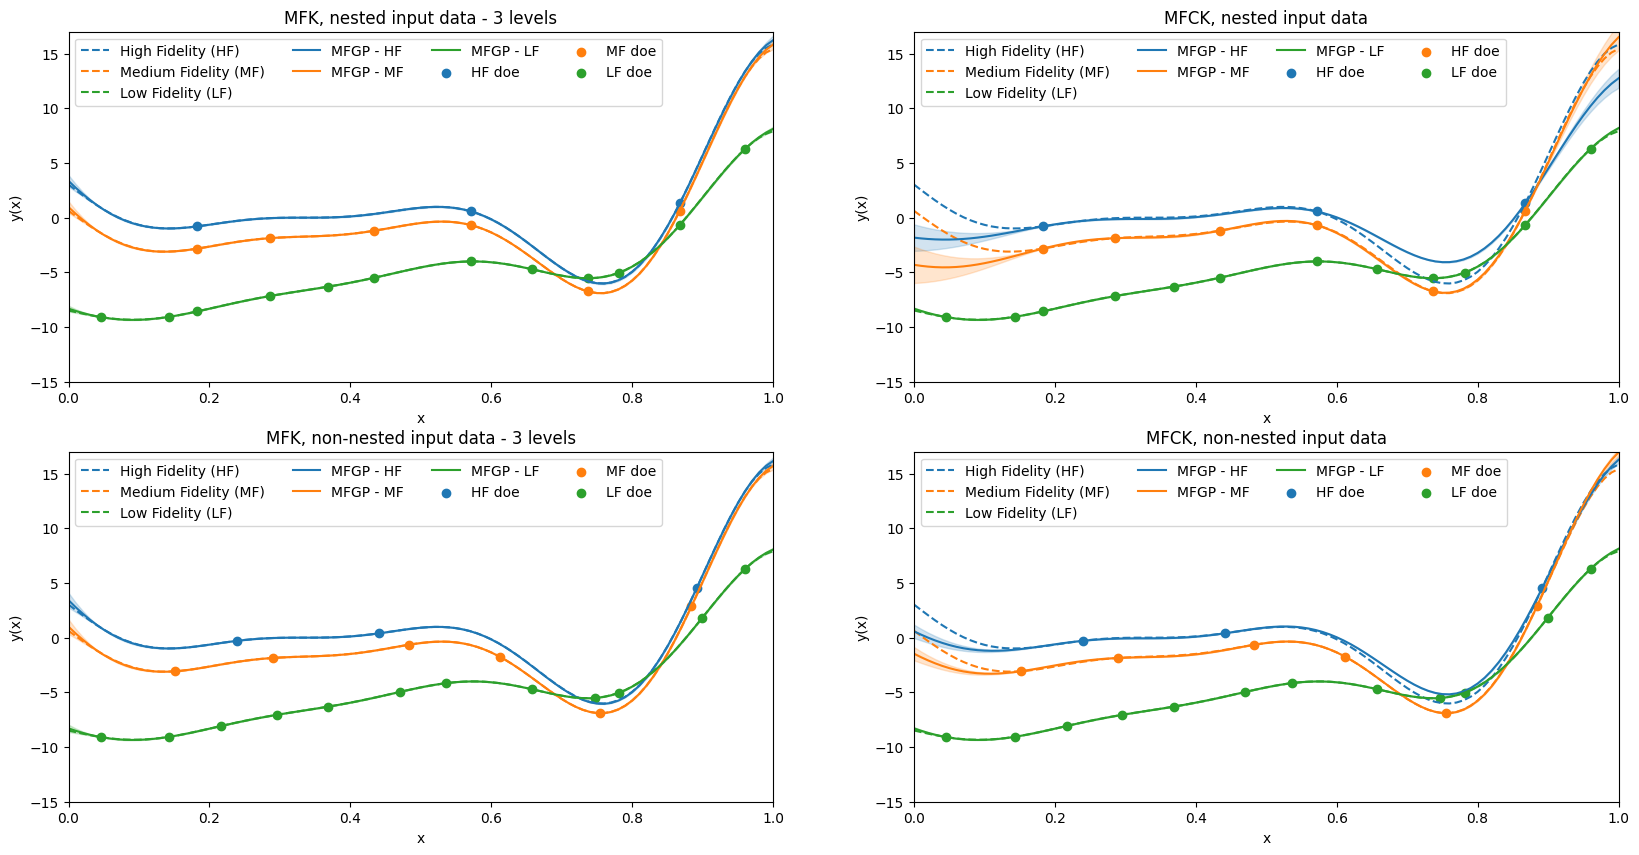

In [22]:
plt.figure(figsize=(20, 10))

plt.subplot(2, 2, 1)
plt.plot(x, Forrester_HF(x), "--C0", label="High Fidelity (HF)")
plt.plot(x, Forrester_MF(x), "--C1", label="Medium Fidelity (MF)")
plt.plot(x, Forrester_LF(x), "--C2", label="Low Fidelity (LF)")

plt.plot(x, y, "C0", label="MFGP - HF")
plt.fill_between(
    np.ravel(x),
    np.ravel(y - 3 * np.sqrt(var)),
    np.ravel(y + 3 * np.sqrt(var)),
    color="C0",
    alpha=0.2,
)
plt.plot(x, y1, "C1", label="MFGP - MF")
plt.fill_between(
    np.ravel(x),
    np.ravel(y1 - 3 * np.sqrt(var1)),
    np.ravel(y1 + 3 * np.sqrt(var1)),
    color="C1",
    alpha=0.2,
)
plt.plot(x, y0, "C2", label="MFGP - LF")
plt.fill_between(
    np.ravel(x),
    np.ravel(y0 - 3 * np.sqrt(var0)),
    np.ravel(y0 + 3 * np.sqrt(var0)),
    color="C2",
    alpha=0.2,
)

plt.scatter(Xt_e, yt_e, color="C0", label="HF doe")
plt.scatter(Xt_m, yt_m, color="C1", label="MF doe")
plt.scatter(Xt_c, yt_c, color="C2", label="LF doe")

plt.ylim(ylimits[0][0], ylimits[0][1])
plt.xlim(xlimits[0][0], xlimits[0][1])
plt.xlabel("x")
plt.ylabel("y(x)")
plt.legend(loc=2, ncol=4)
plt.title("MFK, nested input data - 3 levels")


plt.subplot(2, 2, 2)

plt.plot(x, Forrester_HF(x), "--C0", label="High Fidelity (HF)")
plt.plot(x, Forrester_MF(x), "--C1", label="Medium Fidelity (MF)")
plt.plot(x, Forrester_LF(x), "--C2", label="Low Fidelity (LF)")

plt.plot(x, mean3, "C0", label="MFGP - HF")
plt.fill_between(
    np.ravel(x),
    np.ravel(mean3 - 3 * np.sqrt(variance3)),
    np.ravel(mean3 + 3 * np.sqrt(variance3)),
    color="C0",
    alpha=0.2,
)
plt.plot(x, mean2, "C1", label="MFGP - MF")
plt.fill_between(
    np.ravel(x),
    np.ravel(mean2 - 3 * np.sqrt(variance2)),
    np.ravel(mean2 + 3 * np.sqrt(variance2)),
    color="C1",
    alpha=0.2,
)
plt.plot(x, mean1, "C2", label="MFGP - LF")
plt.fill_between(
    np.ravel(x),
    np.ravel(mean1 - 3 * np.sqrt(variance1)),
    np.ravel(mean1 + 3 * np.sqrt(variance1)),
    color="C2",
    alpha=0.2,
)

plt.scatter(Xt_e, yt_e, color="C0", label="HF doe")
plt.scatter(Xt_m, yt_m, color="C1", label="HF doe")
plt.scatter(Xt_c, yt_c, color="C2", label="LF doe")
plt.ylim(ylimits[0][0], ylimits[0][1])
plt.xlim(xlimits[0][0], xlimits[0][1])
plt.xlabel("x")
plt.ylabel("y(x)")
plt.legend(loc=2, ncol=4)
plt.title("MFCK, nested input data")


plt.subplot(2, 2, 3)
plt.plot(x, Forrester_HF(x), "--C0", label="High Fidelity (HF)")
plt.plot(x, Forrester_MF(x), "--C1", label="Medium Fidelity (MF)")
plt.plot(x, Forrester_LF(x), "--C2", label="Low Fidelity (LF)")

plt.plot(x, yn, "C0", label="MFGP - HF")
plt.fill_between(
    np.ravel(x),
    np.ravel(yn - 3 * np.sqrt(varn)),
    np.ravel(yn + 3 * np.sqrt(varn)),
    color="C0",
    alpha=0.2,
)
plt.plot(x, y1n, "C1", label="MFGP - MF")
plt.fill_between(
    np.ravel(x),
    np.ravel(y1n - 3 * np.sqrt(var1n)),
    np.ravel(y1n + 3 * np.sqrt(var1n)),
    color="C1",
    alpha=0.2,
)
plt.plot(x, y0n, "C2", label="MFGP - LF")
plt.fill_between(
    np.ravel(x),
    np.ravel(y0n - 3 * np.sqrt(var0n)),
    np.ravel(y0n + 3 * np.sqrt(var0n)),
    color="C2",
    alpha=0.2,
)

plt.scatter(x0_HF, y0_HF, color="C0", label="HF doe")
plt.scatter(x0_MF, y0_MF, color="C1", label="MF doe")
plt.scatter(x0_LF, y0_LF, color="C2", label="LF doe")

plt.ylim(ylimits[0][0], ylimits[0][1])
plt.xlim(xlimits[0][0], xlimits[0][1])
plt.xlabel("x")
plt.ylabel("y(x)")
plt.legend(loc=2, ncol=4)
plt.title("MFK, non-nested input data - 3 levels")

plt.subplot(2, 2, 4)
plt.plot(x, Forrester_HF(x), "--C0", label="High Fidelity (HF)")
plt.plot(x, Forrester_MF(x), "--C1", label="Medium Fidelity (MF)")
plt.plot(x, Forrester_LF(x), "--C2", label="Low Fidelity (LF)")

plt.plot(x, mean3n, "C0", label="MFGP - HF")
plt.fill_between(
    np.ravel(x),
    np.ravel(mean3n - 3 * np.sqrt(variance3n)),
    np.ravel(mean3n + 3 * np.sqrt(variance3n)),
    color="C0",
    alpha=0.2,
)
plt.plot(x, mean2n, "C1", label="MFGP - MF")
plt.fill_between(
    np.ravel(x),
    np.ravel(mean2n - 3 * np.sqrt(variance2n)),
    np.ravel(mean2n + 3 * np.sqrt(variance2n)),
    color="C1",
    alpha=0.2,
)
plt.plot(x, mean1n, "C2", label="MFGP - LF")
plt.fill_between(
    np.ravel(x),
    np.ravel(mean1n - 3 * np.sqrt(variance1n)),
    np.ravel(mean1n + 3 * np.sqrt(variance1n)),
    color="C2",
    alpha=0.2,
)

plt.scatter(x0_HF, y0_HF, color="C0", label="HF doe")
plt.scatter(x0_MF, y0_MF, color="C1", label="MF doe")
plt.scatter(x0_LF, y0_LF, color="C2", label="LF doe")

plt.ylim(ylimits[0][0], ylimits[0][1])
plt.xlim(xlimits[0][0], xlimits[0][1])
plt.xlabel("x")
plt.ylabel("y(x)")
plt.legend(loc=2, ncol=4)
plt.title("MFCK, non-nested input data")

## 3.5 RMSE comparison between MFK and MFCK for 3 levels, 1D

In [23]:
# Add RMSE
HF = Forrester_HF(x)
MF = Forrester_MF(x)
LF = Forrester_LF(x)


# MFCK: RMSE HF non-nested
rmseHF_3l = np.sqrt(np.mean((HF.flatten() - mean3n.flatten()) ** 2))
# RMSE Medium Fidelity non-nested
rmseMF_3l = np.sqrt(np.mean((MF.flatten() - mean2n.flatten()) ** 2))
# RMSE Low Fidelity non-nested
rmseLF_3l = np.sqrt(np.mean((LF.flatten() - mean1n.flatten()) ** 2))

# MFK: RMSE HF non-nested
rmseHF1_3l = np.sqrt(np.mean((HF.flatten() - yn.flatten()) ** 2))
# RMSE MF non-nested
rmseMF1_3l = np.sqrt(np.mean((MF.flatten() - y1n.flatten()) ** 2))
# RMSE LF non-nested
rmseLF1_3l = np.sqrt(np.mean((LF.flatten() - y0n.flatten()) ** 2))


# MFCK: RMSE HF nested
rmseHF2_3l = np.sqrt(np.mean((HF.flatten() - mean3.flatten()) ** 2))
# RMSE Medium Fidelity nested
rmseMF2_3l = np.sqrt(np.mean((MF.flatten() - mean2.flatten()) ** 2))
#      RMSE LF nested
rmseLF2_3l = np.sqrt(np.mean((LF.flatten() - mean1.flatten()) ** 2))

# MFK: RMSE LF nested
rmseHF3_3l = np.sqrt(np.mean((HF.flatten() - y.flatten()) ** 2))
# RMSE MF nested
rmseMF3_3l = np.sqrt(np.mean((MF.flatten() - y1.flatten()) ** 2))
#      RMSE LF nested
rmseLF3_3l = np.sqrt(np.mean((LF.flatten() - y0.flatten()) ** 2))

print("RMSE for nested-3 levels")
print("          HF                MF                 LF")
print("MFK  :", rmseHF3_3l, rmseMF3_3l, rmseLF3_3l)
print("MFCK :", rmseHF2_3l, rmseMF2_3l, rmseLF2_3l)


print("\n")

print("RMSE for non-nested-3 levels ")
print("          HF                MF                 LF")
print("MFK  :", rmseHF1_3l, rmseMF1_3l, rmseLF1_3l)
print("MFCK :", rmseHF_3l, rmseMF_3l, rmseLF_3l)

RMSE for nested-3 levels
          HF                MF                 LF
MFK  : 0.06461987225131575 0.06456159523989427 0.03229164490772574
MFCK : 1.5361332702089823 1.095966406645521 0.039787323773343666


RMSE for non-nested-3 levels 
          HF                MF                 LF
MFK  : 0.06532037824620536 0.05711011219152907 0.03000741861900837
MFCK : 0.6203837852781763 0.5035114727265702 0.03572927792386532


## 3.6 To compare  with mono fidelity GP using only HF data

In [24]:
# to compare with mono-fidelity GP build on HF data
# Build the KRG object
from smt.surrogate_models import KRG

gp = KRG(theta0=[1e-2], theta_bounds=[1e-06, 100.0], hyper_opt=opti)
# high-fidelity dataset non nested = nested data for HF (xt_e,yt_e) = (x0_HF, y0_HF)
gp.set_training_values(Xt_e, yt_e)
# train the model
gp.train()

# prediction and variances associated
gp_y = gp.predict_values(x)
gp_var = gp.predict_variances(x)

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 3
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.0353575
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 101
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   


Text(0.5, 1.0, 'Mono or MultiFi Kriging (non nested input data - 3 levels)')

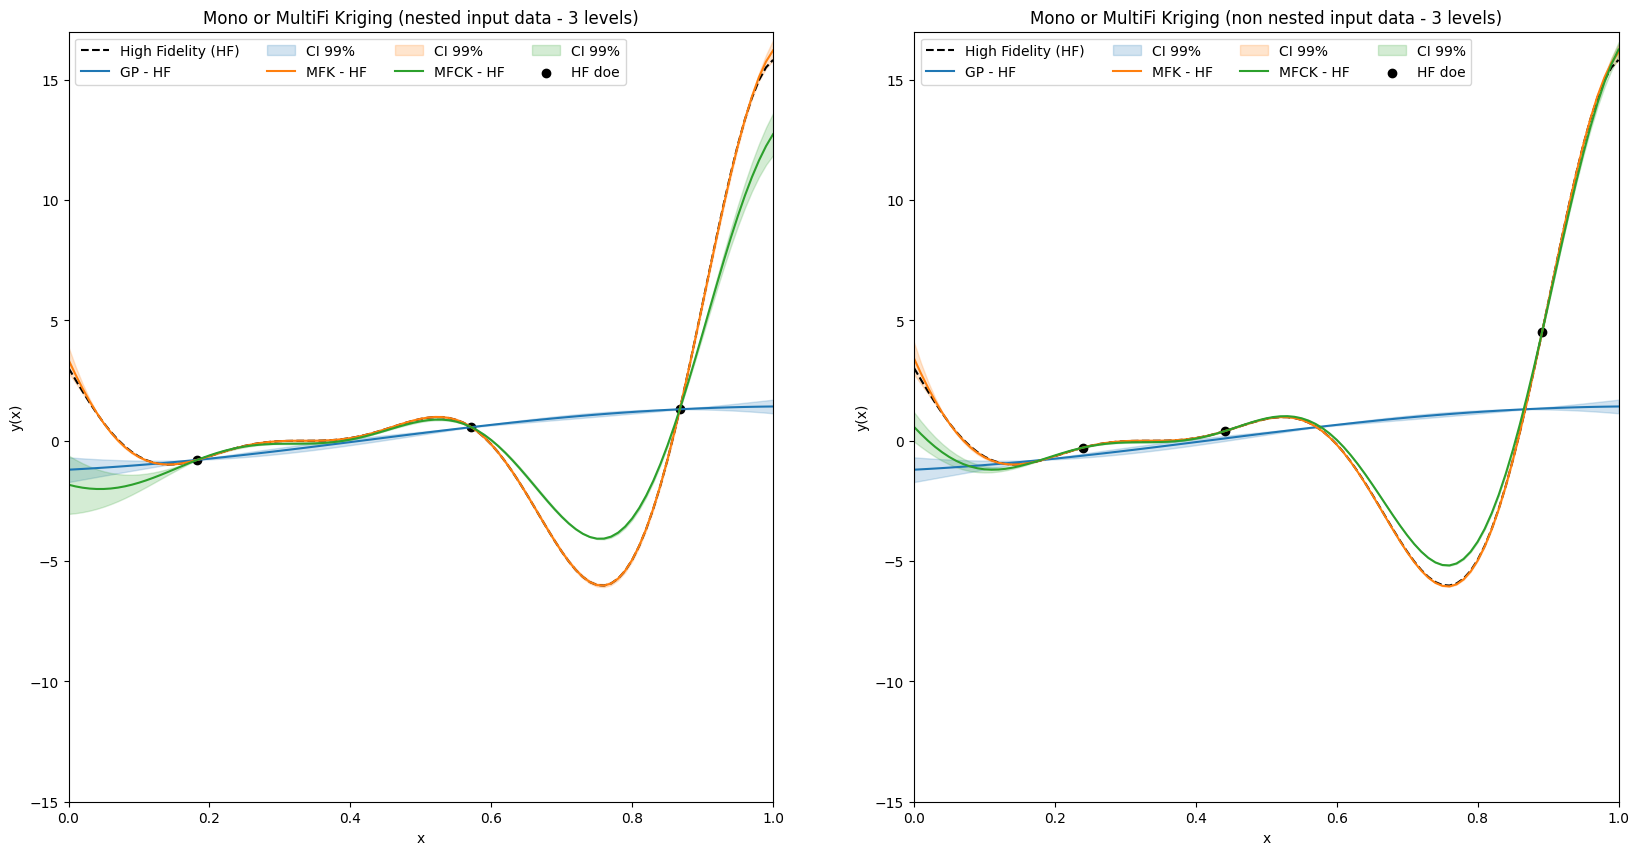

In [25]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(x, Forrester_HF(x), "k--", label="High Fidelity (HF)")

plt.plot(x, gp_y, "C0", label="GP - HF")
plt.fill_between(
    np.ravel(x),
    np.ravel(gp_y - 3 * np.sqrt(gp_var)),
    np.ravel(gp_y + 3 * np.sqrt(gp_var)),
    color="C0",
    label="CI 99%",
    alpha=0.2,
)

plt.plot(x, y, "C1", label="MFK - HF")
plt.fill_between(
    np.ravel(x),
    np.ravel(y - 3 * np.sqrt(var)),
    np.ravel(y + 3 * np.sqrt(var)),
    color="C1",
    label="CI 99%",
    alpha=0.2,
)

plt.plot(x, mean3, "C2", label="MFCK - HF")
plt.fill_between(
    np.ravel(x),
    np.ravel(mean3 - 3 * np.sqrt(variance3)),
    np.ravel(mean3 + 3 * np.sqrt(variance3)),
    color="C2",
    label="CI 99%",
    alpha=0.2,
)
plt.scatter(Xt_e, yt_e, color="black", label="HF doe")


plt.ylim(ylimits[0][0], ylimits[0][1])
plt.xlim(xlimits[0][0], xlimits[0][1])
plt.xlabel("x")
plt.ylabel("y(x)")
plt.legend(loc=2, ncol=4)
plt.title("Mono or MultiFi Kriging (nested input data - 3 levels)")


plt.subplot(1, 2, 2)
plt.plot(x, Forrester_HF(x), "k--", label="High Fidelity (HF)")


plt.plot(x, gp_y, "C0", label="GP - HF")
plt.fill_between(
    np.ravel(x),
    np.ravel(gp_y - 3 * np.sqrt(gp_var)),
    np.ravel(gp_y + 3 * np.sqrt(gp_var)),
    color="C0",
    label="CI 99%",
    alpha=0.2,
)

plt.plot(x, yn, "C1", label="MFK - HF")
plt.fill_between(
    np.ravel(x),
    np.ravel(yn - 3 * np.sqrt(varn)),
    np.ravel(yn + 3 * np.sqrt(varn)),
    color="C1",
    label="CI 99%",
    alpha=0.2,
)

plt.plot(x, mean3n, "C2", label="MFCK - HF")
plt.fill_between(
    np.ravel(x),
    np.ravel(mean3n - 3 * np.sqrt(variance3n)),
    np.ravel(mean3n + 3 * np.sqrt(variance3n)),
    color="C2",
    label="CI 99%",
    alpha=0.2,
)

plt.scatter(x0_HF, y0_HF, color="black", label="HF doe")

plt.ylim(ylimits[0][0], ylimits[0][1])
plt.xlim(xlimits[0][0], xlimits[0][1])
plt.xlabel("x")
plt.ylabel("y(x)")
plt.legend(loc=2, ncol=4)
plt.title("Mono or MultiFi Kriging (non nested input data - 3 levels)")

# 4- Multi-Fidelity co-Kriging: experiments for 2 levels and 2D

In [26]:
from matplotlib import cm


def Rosen_HF(point):
    # Expensive Rosen function
    res = 100 * (point[:, 1] - point[:, 0] ** 2) ** 2 + (1.0 - point[:, 0]) ** 2
    return res


def Rosen_MF(point):
    # Expensive Rosen function
    res = 100 * (point[:, 1] - point[:, 0] ** 2) ** 2 + (2.0 - point[:, 0]) ** 2
    return res


def Rosen_LF(point):
    # Expensive Rosen function
    # res = 5*((1.0 - point[:,0])**2 + 100*(point[:,1] - point[:,0]**2)**2) + 0.1*np.sin(10*point[:,0] + 5*point[:,1])
    res = (
        50 * (point[:, 1] - point[:, 0] ** 2) ** 2
        + (-2 - point[:, 0]) ** 2
        - (0.5 * point[:, 0])
    )
    return res

Sampling for 2D

D:\mcastano\AppData\Local\Temp\ipykernel_4732\3249280182.py:56: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()
D:\mcastano\AppData\Local\Temp\ipykernel_4732\3249280182.py:72: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig2.show()


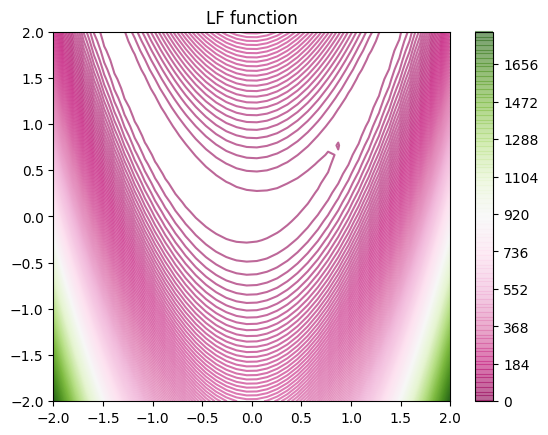

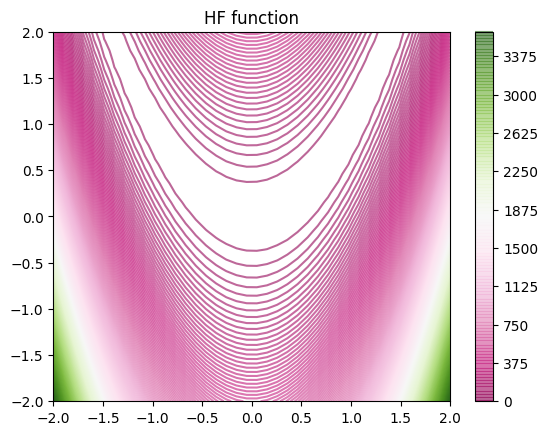

In [27]:
# HF observations
num = 5
x = np.linspace(-2.0, 2.0, num)
y = np.linspace(-2.0, 2.0, num)
xv, yv = np.meshgrid(x, y)
x_hf = np.array([np.ravel(xv), np.ravel(yv)]).T
z_HF = np.zeros([num * num, 1])
z_HF = Rosen_HF(x_hf)

num = 10
x = np.linspace(-2.0, 2.0, num)
y = np.linspace(-2.0, 2.0, num)
xv, yv = np.meshgrid(x, y)
x_mf = np.array([np.ravel(xv), np.ravel(yv)]).T
z_MF = np.zeros([num * num, 1])
z_MF = Rosen_MF(x_mf)

# LF observations
num = 20
x = np.linspace(-2.0, 2.0, num)
y = np.linspace(-2.0, 2.0, num)
xv, yv = np.meshgrid(x, y)

x_lf = np.array([np.ravel(xv), np.ravel(yv)]).T
z_LF = np.zeros([num * num, 1])
z_LF = Rosen_LF(x_lf)

# Test set
num = 40
x = np.linspace(-2.0, 2.0, num)
y = np.linspace(-2.0, 2.0, num)
xv, yv = np.meshgrid(x, y)
x_test = np.array([np.ravel(xv), np.ravel(yv)]).T

z_test_LF = np.zeros([num * num, 1])
z_test_LF = Rosen_LF(x_test).reshape(-1, 1)

z_test_HF = np.zeros([num * num, 1])
z_test_HF = Rosen_HF(x_test).reshape(-1, 1)


# Plots for High and Low fidelity Rosen functions.
fig1 = plt.figure()
axSurrogate1 = fig1.add_subplot(111)
axSurrogate1.set_title("LF function")
surf1 = axSurrogate1.contour(
    xv,
    yv,
    z_test_LF.reshape((num, num)),
    300,
    cmap=cm.PiYG,
    antialiased=True,
    alpha=0.6,
)
fig1.colorbar(surf1)
fig1.show()


fig2 = plt.figure()
axSurrogate2 = fig2.add_subplot(111)
axSurrogate2.set_title("HF function")
surf2 = axSurrogate2.contour(
    xv,
    yv,
    z_test_HF.reshape((num, num)),
    300,
    cmap=cm.PiYG,
    antialiased=True,
    alpha=0.6,
)
fig2.colorbar(surf2)
fig2.show()

## 4.1 Training for 2D/2 levels

In [28]:
# %% Build the MFK object with 2 levels
sm = MFK()
# low-fidelity dataset names being integers from 0 to level-1
sm.set_training_values(x_lf, z_LF, name=0)
# high-fidelity dataset without name
sm.set_training_values(x_hf, z_HF)
# train the model
sm.train()

mean_hf = sm.predict_values(x_test)
va_hf = sm.predict_variances(x_test)
mean_lf = sm._predict_intermediate_values(x_test, 1)

___________________________________________________________________________
   
                                    MFK
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 25
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec): 13.5176902
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1600
   
   Predicting ...
   Predicting - done. Time (sec):  0.0229659
   
   Prediction time/pt. (sec) :  0.0000144
   


In [29]:
# here with 2 levels and 2 diemension so we have 4 hyperparameters
# (number dependant of the dimension as a anistopic kernel is used)
print("Optimal hyperparameters for MFK", sm.optimal_theta)

Optimal hyperparameters for MFK [array([0.57812965, 0.01982759]), array([5.19917801e-04, 1.00000000e-06])]


## 4.2 Training MFCK for 2D/2 levels

In [30]:
# Train MFCK
mfck1 = MFCK(theta0=[1.0], hyper_opt=opti)
mfck1.set_training_values(x_lf, z_LF, name=0)
mfck1.set_training_values(x_hf, z_HF)
mfck1.train()
means, covariances = mfck1.predict_all_levels(x_test)

In [31]:
# here with 2 levels we have 5 hyperparameters
# (number independant of the dimension as an istopic kernel is used)
print("Optimal hyperparameters for MFCK", mfck1.optimal_theta)

Optimal hyperparameters for MFCK [20.09143127  0.54678709  0.02463484  1.04622508  1.32117633  0.14741873
  1.82133806]


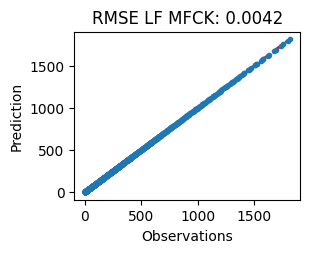

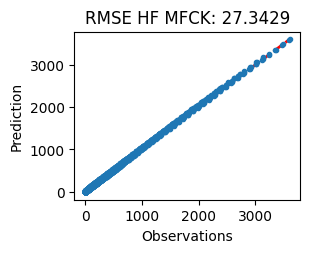

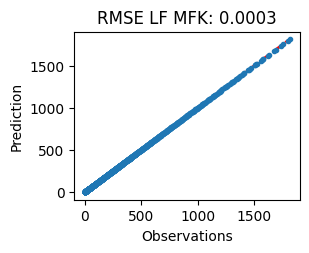

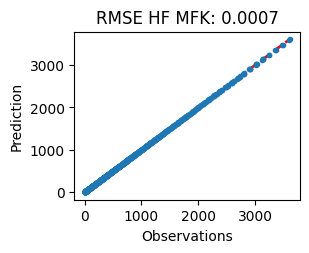

In [32]:
# %%Plot RMSE
# plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
rmse = np.sqrt(np.mean((z_test_LF.flatten() - means[0].flatten()) ** 2))
# Plot results
start = np.min([means[0], z_test_LF])
end = np.max([means[0], z_test_LF])
# plt.figure(figsize=(8,8))
plt.plot([start, end], [start, end], "r--", linewidth=2)
plt.plot(z_test_LF.flatten(), means[0].flatten(), ".")
plt.xlabel("Observations")
plt.ylabel("Prediction")
plt.title("RMSE LF MFCK: %.4f" % rmse)
plt.show()
plt.subplot(2, 2, 2)
rmse = np.sqrt(np.mean((z_test_HF.flatten() - means[1].flatten()) ** 2))
# Plot results
start = np.min([means[1], z_test_HF])
end = np.max([means[1], z_test_HF])
# plt.figure(figsize=(8,8))
plt.plot([start, end], [start, end], "r--", linewidth=2)
plt.plot(z_test_HF.flatten(), means[1].flatten(), ".")
plt.xlabel("Observations")
plt.ylabel("Prediction")
plt.title("RMSE HF MFCK: %.4f" % rmse)
plt.show()
plt.subplot(2, 2, 3)
rmse = np.sqrt(np.mean((z_test_LF.flatten() - mean_lf.flatten()) ** 2))
# Plot results
start = np.min([mean_lf, z_test_LF])
end = np.max([mean_lf, z_test_LF])
plt.plot([start, end], [start, end], "r--", linewidth=2)
plt.plot(z_test_LF.flatten(), mean_lf.flatten(), ".")
plt.xlabel("Observations")
plt.ylabel("Prediction")
plt.title("RMSE LF MFK: %.4f" % rmse)
plt.show()
plt.subplot(2, 2, 4)
rmse = np.sqrt(np.mean((z_test_HF.flatten() - mean_hf.flatten()) ** 2))
# Plot results
start = np.min([mean_hf, z_test_HF])
end = np.max([mean_hf, z_test_HF])
# plt.figure(figsize=(8,8))
plt.plot([start, end], [start, end], "r--", linewidth=2)
plt.plot(z_test_HF.flatten(), mean_hf.flatten(), ".")
plt.xlabel("Observations")
plt.ylabel("Prediction")
plt.title("RMSE HF MFK: %.4f" % rmse)
plt.show()

D:\mcastano\AppData\Local\Temp\ipykernel_4732\3646696591.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig4.show()
D:\mcastano\AppData\Local\Temp\ipykernel_4732\3646696591.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig3.show()


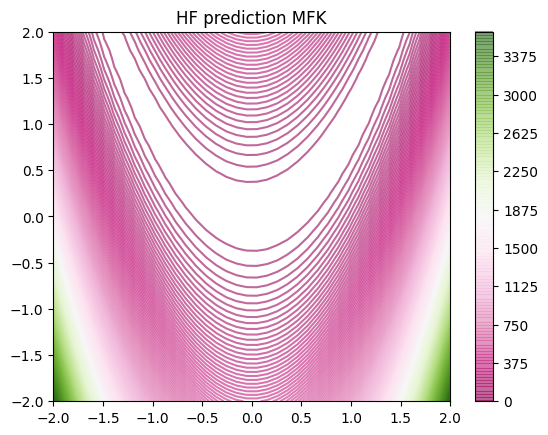

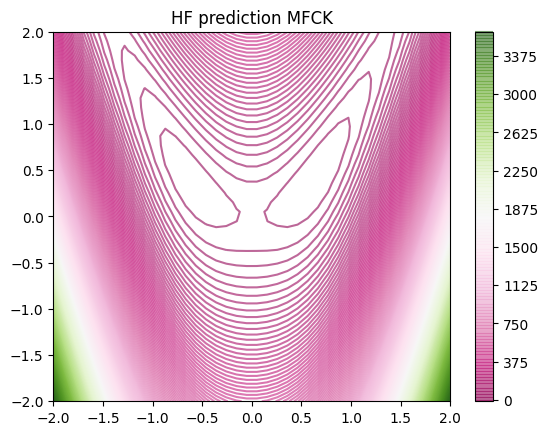

In [33]:
# To compare the prediction
fig4 = plt.figure()
axSurrogate4 = fig4.add_subplot(111)
axSurrogate4.set_title("HF prediction MFK")
surf4 = axSurrogate4.contour(
    xv, yv, mean_hf.reshape((num, num)), 300, cmap=cm.PiYG, antialiased=True, alpha=0.6
)
fig4.colorbar(surf4)
fig4.show()

fig3 = plt.figure()
axSurrogate3 = fig3.add_subplot(111)
axSurrogate3.set_title("HF prediction MFCK")
surf3 = axSurrogate3.contour(
    xv, yv, means[1].reshape((num, num)), 300, cmap=cm.PiYG, antialiased=True, alpha=0.6
)
fig3.colorbar(surf3)
fig3.show()

The complexity in the optimization process of MFCK increases with respect to MFK as the amount of hyperparameters are higher in this block-wise matrix formulation.